# Data Bootcamp Final Project: Rural-Urban Inequality in Tanzania 
<br>
<br>

<div class="inline-block"> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Flag_of_Tanzania.svg/1200px-Flag_of_Tanzania.svg.png" style="width: 200px;"/> </div> 

**Author: Michael Waugh**

**Email: [mwaugh@stern.nyu.edu](mwaugh@stern.nyu.edu)**

Poor countries have large masses of their population in rural, agriculture areas. Within these areas, [they earn and produce less relative to urban, non-agriculture areas](http://www.waugheconomics.com/uploads/2/2/5/6/22563786/apg.pdf). This observation begs the question: if people moved from rural to urban areas, would they reap gains in living standards. Or are the observed differences in livings standars simply and artifact of, say, differences in education or (unobserved) ability. This project uses the Tanzania LSMS dataset to document and understand rural-urban inequality.

This project will explore these issues in several steps:
1. I'll describe the data and its source 
2. Discuss the tools and packages that I will used to anaylze the data.
3. Primary Analysis
4. Extension to studying those that move.

## Data Report

The key elements of the data are from the [LSMS surveys](http://go.worldbank.org/IPLXWMCNJ0) from the [World Bank](http://www.worldbank.org/). The LSMS datasets are designed to measure living standards in countries where standard measurment apaparatuses (e.g. like the Census in the US) are not present. Access to the Tanzania dataset is free, but you must apply for access. The World Bank's website for the Tanzania LSMS dataset is here:

http://go.worldbank.org/EJMAC1YDY0

All data is stored in the `.dta` stata format. This is not a problem since we can use `pd.read_stata` command. There are many modules (sheets of data with different subject areas). Within each module there are the household responses and then a houshold id that can be used to link the responses across datasheets. I'm going to focus on only a couple of the datasets. The are discussed below:
- `TZY1.HH.Consumption.dta` and `TZY2.HH.Consumption.dta` is the consumption module in year one in 2008-2009 and the year two in 2011-2012 (?). The key element is that there is a "consumption aggregate" that reports aggregate expenditures by households. It also reports [adlut equivalents](https://en.wikipedia.org/wiki/Equivalisation), then per capita consumption within the houshold can be computed as the ratio of expenditures relative to adult equivalents. **This is the main variable of interest.** 
- Also within these data is the classification of households by if they live in a rural or urban area. This classification will be of interst as well as we examive differences in consumption by classification. 
- `HH.Geovariables_Y2.dta` is the geographic module that contains the coordinates of the household within year two. This will be used to map households locations and outcomes associated with those households.
- There is also an education module. This will be used to explore the role of differences in education or "human capital" in explaining rural-urban gaps in earnings. 

**Data Disclaimer:** Because this data is restricted access, I will pull the data directly from that saved on my local computer.

## My Packages

In the analysis below, I'm goint to use the following packages:
- `display` package which will display certain output in a nice way
- `Pandas` package which will be my core tool to import, manipulate, merge, and analyze the data
- `Matplotlib` package which will assiste me in ploting my results
- `numpy` which will allow me to perform certain mathimatical operations and transformations of the data (e.g. log of stuff). 
- `Basemap` which will allow me to map certain featurs of the data.
- `statsmodels` will allow me to perform regresion analysis on my data.

Then there are several new pacakges (not familiar to us in class). These are:
- `geopandas` which creates dataframe like objects with "shapes" to create maps.
- `shapely` which helps create shapes 
- `fiona` which is required (not sure what it does though)

In [1]:
from IPython.display import display, Image # Displays things nicely
import pandas as pd # Key tool 
import matplotlib.pyplot as plt # Helps plot
import numpy as np # Numerical operations
from mpl_toolkits.basemap import Basemap # Basemap

import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona

from geopy.distance import great_circle #importing geopy for distance calculations

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Organize the Data

Below I walk through the steps to organize the data. I proceed by reading in the datasets, but only pull in the columns that I care about. I do this for the two years of consumption data, the geographic variables, and then the education data. I then merge the datasets together.

Below are the paths to the files on my local computers:

In [2]:
path_laptop = "C://Users//mwaugh//Dropbox//Panel Tracking Surveys//Tanzania//Raw Data (2008-2009 and 2010-2011)"
path_desktop = "C://Users//mwaugh.NYC-STERN//Dropbox//Panel Tracking Surveys//Tanzania\Raw Data (2008-2009 and 2010-2011)"

#### Bring in Year 1 Consumpiton Data

In [3]:
file = path_desktop + "//TZY1.HH.Consumption.dta"

myvars = ["hhid", "urban", "expmR", "adulteq", "hhsize", "hhweight", "region"]

tanz_y1 = pd.read_stata(file, columns = myvars)

tanz_y1.columns

new_name = []

for name in myvars:
    new_name.append(name + "_y1")
    
tanz_y1.columns = new_name

Then I want to create the consumption per adult equivalent measure and then lets look at the data.

In [4]:
tanz_y1["cons_y1"] = tanz_y1["expmR_y1"] / tanz_y1["adulteq_y1"]

display(tanz_y1.head(5))

,hhid_y1,urban_y1,expmR_y1,adulteq_y1,hhsize_y1,hhweight_y1,region_y1,cons_y1
0,01010140020171,Rural,1.730037e+06,4.52,5,5048.136719,Dodoma,382751.572895
1,01010140020284,Rural,4.539407e+05,2.28,3,5048.136719,Dodoma,199096.806365
2,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,896497.671583
3,01010140020409,Rural,1.523027e+06,2.84,4,5048.136719,Dodoma,536277.156015
4,01010140020471,Rural,1.416735e+06,3.52,5,5048.136719,Dodoma,402481.539679


#### Bring in Year 2 Consumption Data

In [5]:
file = path_desktop + "//TZY2.HH.Consumption.dta"

myvars = ["y2_hhid", "hhid_2008", "urban", "expmR", "adulteq", "hhsize", "hhweight", "region"]

tanz_y2 = pd.read_stata(file, columns = myvars)

new_name = []

for name in myvars:
    new_name.append(name + "_y2")
    
tanz_y2.columns = new_name


Then compute consumption per adult equivalent as well for year 2.

In [6]:
tanz_y2["cons_y2"] = tanz_y2["expmR_y2"] / tanz_y2["adulteq_y2"]

display(tanz_y2.head(5))

,y2_hhid_y2,hhid_2008_y2,urban_y2,expmR_y2,adulteq_y2,hhsize_y2,hhweight_y2,region_y2,cons_y2
0,0101014002017101,01010140020171,Rural,2453002.750,4.24,5,5152.955078,Dodoma,578538.383133
1,0101014002028401,01010140020284,Rural,1364008.375,2.76,4,5212.386719,Dodoma,494205.934679
2,0101014002029701,01010140020297,Rural,6136596.000,8.12,10,2564.016113,Dodoma,755738.420428
3,0101014002029704,01010140020297,Urban,3419913.000,6.36,8,3052.347412,Dar es Salaam,537722.171122
4,0101014002040901,01010140020409,Rural,1228936.250,4.16,6,5152.955078,Dodoma,295417.370159


Before we merge, lets look at the shape of each file so we completely understand what is going on.

In [7]:
print(tanz_y1.shape)
print(tanz_y2.shape)

(3265, 8)
(3846, 9)


**Two observations:**

- So the number of columns is different, this is because year two a 2008 household id and then a new id for 2012; hence the additional column.
- The number of rows is different. I suspect that the reason is that some housholds "broke up" in between the time periods. So in 2012, they are represented as a new additional houshold. 

One way to get a better understanding of this point is to look at how many unique 2008 household id's there are in the year two data set:

In [8]:
display(tanz_y2.hhid_2008_y2.unique().shape)

(3166,)

This is a bit surprising. What it looks like is two things going on. Some households are not connected across the sample; this may because they are unable to be found when conducting the year two data set, refused to participate, etc. Then there is the fact that year two has about 400 extra housholds why? This is an open quesiton.

#### Merge Year 1 and Year 2 

Now lets merge the datasets together on the 2008 hosehold id.

In [9]:
tanz = pd.merge(tanz_y1, tanz_y2, how='inner',
                         left_on = "hhid_y1", right_on = "hhid_2008_y2", indicator = True)

display(tanz.head(5))
display(tanz.shape)

,hhid_y1,urban_y1,expmR_y1,adulteq_y1,hhsize_y1,hhweight_y1,region_y1,cons_y1,y2_hhid_y2,hhid_2008_y2,urban_y2,expmR_y2,adulteq_y2,hhsize_y2,hhweight_y2,region_y2,cons_y2,_merge
0,01010140020171,Rural,1.730037e+06,4.52,5,5048.136719,Dodoma,382751.572895,0101014002017101,01010140020171,Rural,2453002.750,4.24,5,5152.955078,Dodoma,578538.383133,both
1,01010140020284,Rural,4.539407e+05,2.28,3,5048.136719,Dodoma,199096.806365,0101014002028401,01010140020284,Rural,1364008.375,2.76,4,5212.386719,Dodoma,494205.934679,both
2,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,896497.671583,0101014002029701,01010140020297,Rural,6136596.000,8.12,10,2564.016113,Dodoma,755738.420428,both
3,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,896497.671583,0101014002029704,01010140020297,Urban,3419913.000,6.36,8,3052.347412,Dar es Salaam,537722.171122,both
4,01010140020409,Rural,1.523027e+06,2.84,4,5048.136719,Dodoma,536277.156015,0101014002040901,01010140020409,Rural,1228936.250,4.16,6,5152.955078,Dodoma,295417.370159,both


(3846, 18)

Then I'm going to drop values if the merge did not work on both sides. I can check if this matters or not later.

In [10]:
display(tanz[tanz._merge == "both"].shape)

(3846, 18)

Looks like nothing was dropped. Future investigations should look at how the sample size is changing across years and understand exactly what is going on.

#### Merge with Year 2 Geography Variables

Below, I merge stuff in with the year 2 geography stuff... I tried to bring in year 1, but the geography variables are exactly the same! See all the commented code below. 

In [11]:
file = path_desktop + "//HH.Geovariables_Y2.dta"

geo_var = pd.read_stata(file, columns = ["y2_hhid", "lat_modified", "lon_modified"])

#geo_var.rename(columns = {"lat_modified":"lat_modified_y2", 
#                          "lon_modified":"lon_modified_y2" }, inplace = True)

tanz = pd.merge(geo_var, tanz, how='inner',
                         left_on = "y2_hhid", right_on = "y2_hhid_y2")

display(tanz.head())

,y2_hhid,lat_modified,lon_modified,hhid_y1,urban_y1,expmR_y1,adulteq_y1,hhsize_y1,hhweight_y1,region_y1,...,y2_hhid_y2,hhid_2008_y2,urban_y2,expmR_y2,adulteq_y2,hhsize_y2,hhweight_y2,region_y2,cons_y2,_merge
0,0101014002017101,-5.08575,35.854389,01010140020171,Rural,1.730037e+06,4.52,5,5048.136719,Dodoma,...,0101014002017101,01010140020171,Rural,2453002.750,4.24,5,5152.955078,Dodoma,578538.383133,both
1,0101014002028401,-5.08575,35.854389,01010140020284,Rural,4.539407e+05,2.28,3,5048.136719,Dodoma,...,0101014002028401,01010140020284,Rural,1364008.375,2.76,4,5212.386719,Dodoma,494205.934679,both
2,0101014002029701,-5.08575,35.854389,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,...,0101014002029701,01010140020297,Rural,6136596.000,8.12,10,2564.016113,Dodoma,755738.420428,both
3,0101014002029704,-5.08575,35.854389,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,...,0101014002029704,01010140020297,Urban,3419913.000,6.36,8,3052.347412,Dar es Salaam,537722.171122,both
4,0101014002040901,-5.08575,35.854389,01010140020409,Rural,1.523027e+06,2.84,4,5048.136719,Dodoma,...,0101014002040901,01010140020409,Rural,1228936.250,4.16,6,5152.955078,Dodoma,295417.370159,both


Here 

In [12]:
#file = path_desktop + "//HH.Geovariables_Y1.dta"

#geo_var = pd.read_stata(file)

#geo_var.rename(columns = {"lat_modified":"lat_modified_y1", 
#                          "lon_modified":"lon_modified_y1" }, inplace = True)

#geo_var.columns

#tanz = pd.merge(geo_var, tanz, how='inner',
 #                        left_on = "hhid", right_on = "hhid_y1")

#geo_var.head()

#test = tanz.apply(                # distance information in new column 'distance'
#    lambda x: great_circle((x['lat_modified_y1'], x['lon_modified_y1']), # function set geopy great circle
#                           (x['lat_modified_y2'], x['lon_modified_y2'])).miles, axis = 1)

#tanz[tanz['lat_modified_y1'] != tanz['lat_modified_y2']]

## Aggregate, Cross-Sectional Analysis

Below, I first describe some summary statistics of the data focusing on the cross-sectional dimension. That is only within one year.

#### Consumption Data

I'm going to first look at the level of consumption in each year and then look at consumption growth across the years. So first, the level of consumption.

In [13]:
convert_to_dollars = 0.0004455530 # For December 2008 (seems stable)

y1sum = (tanz.cons_y1*convert_to_dollars).describe()

y2sum = (tanz.cons_y2*convert_to_dollars).describe() # Each of these are a series

sum_data = pd.concat([y1sum, y2sum], axis = 1) # Then use the concat method to create a dataframe
                                               # Which will give a nice visualization of the table
display(sum_data)

,cons_y1,cons_y2
count,3839.000000,3838.000000
mean,331.580256,390.151393
std,322.710943,354.803545
min,20.761887,32.411519
25%,151.305534,181.533352
50%,231.436136,280.455998
75%,385.517895,465.369968
max,6772.997294,3631.400641


A couple of things to note:
- So about 4000 households. Note how it looks like there are two less in year 2. Might want to investigate this at some point.
- On average, mean consumption increased. We will discuss this below. 
- Very poor. Average level of consumption is between 300 and 400 USD. Need to verify the time frame it covers, but no matter what this is poor, e.g. I spend that much on coffee and beer in a month probably. 
- Also, it looks like the dispersion is similar across the two years. Might want to do this is logs to verify. Latter we will visually inspect this.

Following up on a point made above: How much consumption growth was there? There are several different ways to get at this. What I will do is compute consumption growth at the household level, then report summary statistics for them. 

In [14]:
tanz["cons_growth"] = 100*(np.log(tanz.cons_y2) - np.log(tanz.cons_y1))

display(pd.DataFrame(tanz.cons_growth.describe()))

,cons_growth
count,3838.000000
mean,17.142055
std,61.781567
min,-256.092485
25%,-21.449128
50%,16.335116
75%,54.500076
max,281.055002


Key observation: **Average consumption growth was 17 percent over four years**. A quick google search suggests this is not inconsistent with national growth rates of GDP.  Also note the dispersion: Some households experienced large disasters. For example, a household in the 25th percentile experienced a **-21** percent drop in consumption. 

#### Rural Urban Status

Now lets examine the fraction of the households by rural or urban status. The first step to do this is I want to be able to perform a numerical calculation on the catagorical status of Rural or Urban. To do so, I need to use the `np.where` operation to compute it:

In [15]:
tanz["num_urban_y1"] = np.where(tanz["urban_y1"] == "Rural", 1, 0) # Creates a numerical catagorication of one or zero base on 
                                                                   # rural or ubran status
tanz["num_urban_y2"] = np.where(tanz["urban_y2"] == "Rural", 1, 0) # for year two

Then lets report some descriptive statistics.

In [16]:
y1sum = tanz.num_urban_y1.describe()
y2sum = tanz.num_urban_y2.describe()

sum_data = pd.concat([y1sum, y2sum], axis = 1) # Then use the concat method to create a dataframe
                                               # Which will give a nice visualization of the table

display(sum_data.loc[["count","mean"]]) #Only show the count and the mean

,num_urban_y1,num_urban_y2
count,3839.000000,3839.00000
mean,0.643918,0.67231


Key observation: **In year one and year two about 60+ percent of the housholds live in rural areas.** Note that it appears that the fraction of rural housholds actually increased in year two. The one issue with this is that these are simple means and not using the sampling weights that are provided. Should update in the future.

#### Rural Urban Gaps in Living Standards

The final point is to report differences in living standard between rural and urban areas. 

In [17]:
years = ["_y1", "_y2"]

cons_gap_mean = []
cons_gap_median = []

for var in years:
    cons_gap_mean.append(tanz[(tanz["urban" + var]== "Urban") ]["cons" + var].mean() /
                 tanz[(tanz["urban"+ var]== "Rural") ]["cons" + var].mean() )
    
    cons_gap_median.append(tanz[(tanz["urban" + var]== "Urban")]["cons" + var].median() /
                 tanz[(tanz["urban"+ var]== "Rural") ]["cons" + var].median() )
    
cons_gap_mean = pd.DataFrame(cons_gap_mean)
cons_gap_median = pd.DataFrame(cons_gap_median)

sum_data = pd.concat([cons_gap_mean, cons_gap_median], axis = 1)

sum_data.columns = ["year one", "year two"]

sum_data.head()

,year one,year two
0,2.156255,1.959750
1,1.959163,1.918165


Here what we see is that: rural areas earn substantially less than urban areas. In 2008, this was by a factor of 2. It appears it shrank slightly in 2012. 

This observation is consistent with prior research that finds large gaps. Moreover, note that this gap (from an accounting perspective) matters as most of the Tanzanian population is Rural. Thus, from a mechanical perspective...why is Tanzania really poor? Well most of their population is rural.

## Geographic Dimensions of Rural-Urban Inequality

Lets look at a couple of dimeionsons of rural-urban inequality. One is across the regions in Tanzania. Another is across unique geo-codes. In the analysis below, I'm going to focus on year 2 for several reasons. One is that Zanzibar appears to be miscoded with respect to urban-rural status. Second, Geocodes are all for year 2. So we will go with that.

### Rural-Urban Inequality By Region 

The idea her is to plot average consumption by region relative to their rural-urban share. Thus, this is exploiting the variation in different regions urbanization and exploring how their relative living standards all matches up. I also want to look at **within region** rural-urban consumption gaps. So within a region, do urban households eat more than rural households.

The first step to performing this analysis is to `groupby` on the region variable and then construct the appropriate variables.

In [18]:
year = "_y2"

grouped = tanz.groupby(("region" + year)) # Groupby region and year

avg_reg_cons = grouped["expmR" + year].sum() / grouped["adulteq"+ year].sum() # Average consumption 

avg_reg_cons = avg_reg_cons/avg_reg_cons.mean() # Normalize it relative to the aggregate mean

frac_rural = grouped["num_urban" + year].mean() # regional rural urbanization

frac_urban = 1-frac_rural

size = 0.007*grouped["hhweight"+ year].sum() # How important different regions are

Then I'm going to group by region and rural urban. This is interesting as it generates a multi-index (worth looking at), then from there I `unstack` things which essentially rotates the indexes into a column. From there I can create a series of the **within region** 

In [19]:
grouped = tanz.groupby([("region" + year), "urban" + year]) # Groupby region and year

reg_gap = grouped["cons" + year].mean() #/ grouped["adulteq"+ year].sum() # Average consumption 

reg_gap = reg_gap.unstack(level=-1)

reg_wage_gap =  reg_gap["Urban"] / reg_gap["Rural"]

#reg_wage_gap.head()

Then lets create a dataframe with our consumption, urbanization, and regional rural-urban gap.

In [20]:
region_data = pd.concat([avg_reg_cons, frac_urban, reg_wage_gap], axis = 1) # Create a dataframe

region_data.columns = ["avg_reg_cons", "frac_urban", "reg_wage_gap"] # rename the columns so this makesense

Then I'm going to regress consumption on the urban share of each region. The reason I'm doing this is so I can generate a best fit line plot on top of our scatter plot. After the discussion of the graph, I'll discuss the results as well.

In [21]:
results = smf.ols('''avg_reg_cons ~ frac_urban''', 
                  data= region_data).fit()  # Then use stats models to estimate the linear relationship

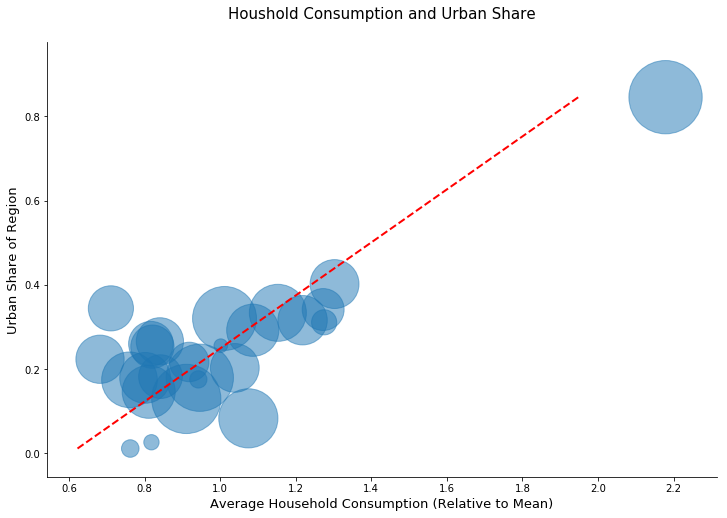

In [22]:
fig, ax = plt.subplots(figsize = (12,8))

ax.scatter(region_data.avg_reg_cons, region_data.frac_urban, s = size, alpha = 0.50)

ax.set_title("Houshold Consumption and Urban Share\n", fontsize = 15)
ax.set_ylabel("Urban Share of Region", fontsize = 13) 
ax.set_xlabel("Average Household Consumption (Relative to Mean)", fontsize = 13)

##### Now plot the best fit line

pred = results.predict(exog = region_data["frac_urban"].sort_values())

ax.plot(pred, region_data["frac_urban"].sort_values(),
        color = 'r', linewidth = 2.0, linestyle = "dashed", label = "Best Fit Line")

##### Make it look nice

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

The figure shows a very clear, systematic relationship between consumption and the Urban Share of a region. If we look closely, the outlier in the upper-right hand corner is Dar Es Salam, i.e. the major urban center of Tanzania. 

What to make of this? Urbanization seems to matter a lot. A way to get a more formal sense of this is to look at the statistics from the regression:

In [23]:
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avg_reg_cons   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     50.57
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           2.37e-07
Time:                        16:13:32   Log-Likelihood:                 9.5959
No. Observations:                  26   AIC:                            -15.19
Df Residuals:                      24   BIC:                            -12.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6050      0.065      9.279      0.000       0.470       0.740
frac_urban     1.5887      0.223      7.111      0.000       1.128       2.050
==============================================================================
Omnibus:                        2.220   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                1.165
Skew:                          -0.499   Prob(JB):                        0.559
Kurtosis:                       3.281   Cond. No.                         6.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Where we see that the **Urban share explains almost 70 percent of the variation in consumption.** And this is all within Tanzania variation. One interesting question to follow up on would be to look at the cross-country evidence: For example, how much variation in cross-country income inequality is explained by the urban share. And is the slope, similar to the within country evidence?

Now lets plot the rural-urban gap by region. This is interesting because what we don't know is the aggregate gap basically, a all vs. Dar es Salaam thing. Or is this always urban-rural no matter which region we are in. A second region why this is interesting is that most rural-urban moves (discussed later) are actually within region, not across. Thus this graph helps set the stage to understand the gains from moving more. The code follows essentially the same strategy as above. 

In [24]:
results = smf.ols('''reg_wage_gap ~ frac_urban''', 
                  data= region_data).fit()  # Then use stats models to estimate the linear relationship

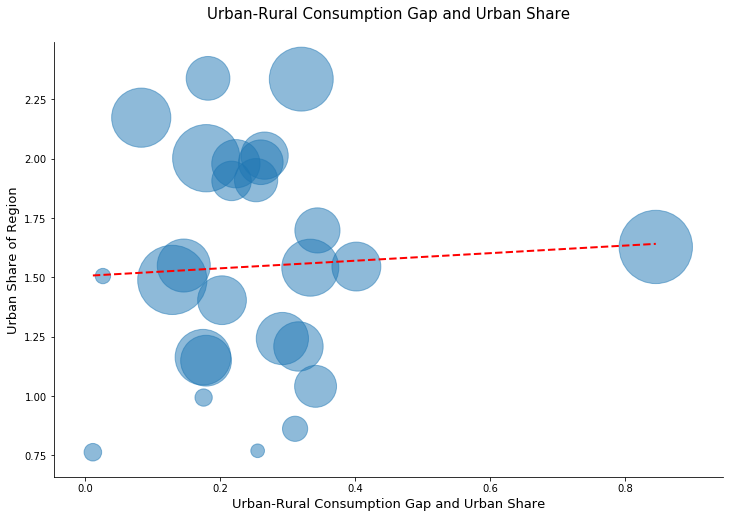

In [25]:
fig, ax = plt.subplots(figsize = (12,8))

ax.scatter( region_data.frac_urban, region_data.reg_wage_gap, s = size, alpha = 0.50)

ax.set_title("Urban-Rural Consumption Gap and Urban Share\n", fontsize = 15)
ax.set_ylabel("Urban Share of Region", fontsize = 13) 
ax.set_xlabel("Urban-Rural Consumption Gap and Urban Share", fontsize = 13)

##### Now plot the best fit line

pred = results.predict(exog = region_data["frac_urban"].sort_values())

ax.plot(region_data["frac_urban"].sort_values(), pred, 
        color = 'r', linewidth = 2.0, linestyle = "dashed", label = "Best Fit Line")

##### Make it look nice

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

This is slightly surprising; In fact, it is not quite what I was expecting...not sure. First, Dar es Salaam's urban-rural gap is "average". Within the other regions, most all are larger than one. However, there are many regions with gaps even larger than Dar es Salaam.

### Mapping Regional Rural-Urban Inequality

Below is a new mapping technology that I sorted out. It will allow me to cleanly create a Cholorpath map for Tanzania and chart the relationship between a region, urban share, and consumption on a map. The first step is to get "shape files" for Tanzania. I did this by googeling and the national statistical agency has one here:

http://www.nbs.go.tz/nbstz/index.php/english/statistics-by-subject/population-and-housing-census/258-2012-phc-shapefiles-level-one-and-two

Then using the `geopandas` package, I create a `geodataframe` that essentially has (i) pandas like functionality but (ii) in one of the columns there is a geometry of the particular entry. It is this geometry field/column that is used to create maps, distance, etc.

In [26]:
path = "C:\\Users\\mwaugh.NYC-STERN\\Dropbox\\NYU TEACHING\\Data Boot Camp Fall 2017"
regions_shape = path + "\\Regions.shx"

# This will read in the shape file...there is some odd dependencies, also note the way the backslashes are operateing.

tanz_map = gpd.read_file(regions_shape)

# Then just like in pandas, I read in the file....

tanz_map.replace(to_replace=['Dar es salaam',"Mjini Magharibi"], 
                 value=["Dar es Salaam","Mjini/Magharibi Unguja"],
                 inplace = True)

# The names don't exactly match up, so I'm going to change them

Then I want some cities to sit on top of this so...I found the following on google by asking "latitude and longitude of X in Tanzania" where X is a city that I was aware of. Then using this information, I created my own geodataframe "by hand" so I can map these cities on top of it.

In [27]:
coordinates = [(39.20,-6.79 ), (40.1760,-10.3112) , (35.7516,-6.1630), (32.9175,-2.5164), (36.6830, -3.3869)]

citynames = ["Dar Es Salam", "Mtwara", "Dodoma", "Mwanza", "Arusha"]

newdata = gpd.GeoDataFrame()
newdata['geometry'] = None
newdata['city_name'] = None

# Then this generates a geodataframe, the key thing is to populate it with 
# the geometry file...

# This was a very helpfull reference on this operation
#https://automating-gis-processes.github.io/2016/course-info.html

count = 0

for var in coordinates:
    point = Point(var) # converts the coordingates in to a "point" shape
    
    newdata.loc[count,'geometry'] = point # populate
    
    count = count + 1 # update counter

#### Key Step: Merging the Data with the GeoDataFrame

Now I want to merge my regional data with the geodataframe. This was fairly straight forward. One key issue is that using a `pd.merge` works, but generated the wrong type. So I used the `.merge` method for the geodataframe. 

In [28]:
region_data.reset_index(inplace = True)

region_data.rename(columns = {"region_y2":"Region_Nam"}, inplace = True)

region_data["log_cons"] = np.log(region_data.avg_reg_cons)

tanz_map  = tanz_map.merge(region_data, on='Region_Nam', how = "outer")
# Need to use GEOPANDAS merge to keep the type, pd.merge works, its 
# just that the new type is a dataframe, maybe conversion is possible?
# I took the outer as I want the shapes to be there for the regions (a couple)
# for which there is no data.

#tanz_map.head(10)

Now lets create the map. This is essentially just matplotlib syntax....

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


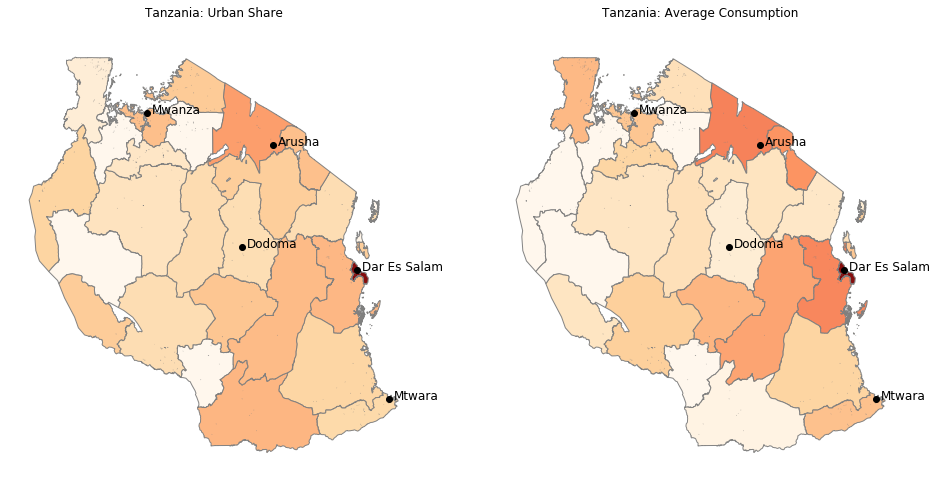

In [29]:
fig, ax = plt.subplots(1,2,figsize = (16,8))

# First create the map for the urban share

tanz_map.plot(ax = ax[0], edgecolor='tab:grey', column='frac_urban', cmap='OrRd', alpha = 0.95)

newdata.plot(ax = ax[0], color = 'k')

######################################################################################
# populate with the city names
count = 0
for var in coordinates:
    
    citynames[count]
    
    ax[0].text(var[0]+0.15,var[1],citynames[count], fontsize = 12)
    
    count = count + 1

######################################################################################    
# Make it look preety...

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[0].set_title("Tanzania: Urban Share\n")

######################################################################################
######################################################################################
# Then lets create the map for consumption...

tanz_map.plot(ax = ax[1], edgecolor='tab:grey', column='log_cons', cmap="OrRd", alpha = 0.95)

newdata.plot(ax = ax[1], color = 'k')

######################################################################################
# populate with the city names
count = 0
for var in coordinates:
    
    citynames[count]
    
    ax[1].text(var[0]+0.15,var[1],citynames[count], fontsize = 12)
    
    count = count + 1

######################################################################################    
    
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[1].set_title("Tanzania: Average Consumption\n")


plt.show()

Let me explain this: On the left panel, lighter regions are more rural, darker being urban. Here you see that around Dar Es Salam, or Arusha, there are urban households.  On the right panel there is the consumption per adult equivalent at the household. Darker areas have higher levels of consumption. One obvious takeaway is that the urban areas in space, have higher levels of consumption.

A second, more subtle issue is note how the regions near Dar es Salam, though relatively rural appear much better off. A similar situation is seen around Arusha. In fact, what this looks like is some kind of "spillover" from urban areas into the surrounding regions.  

### Where do the Households Live?

Lets generate a similar map and plot on top of it where the households are located.

**Step one: Groupby the location.**

In [30]:
tanz["rural_y2"] = 1-tanz["num_urban_y2"]

geo_group = tanz.groupby(["lat_modified","lon_modified"])

cnt = geo_group.agg({"cons_y2": "mean", "y2_hhid_y2": "count", "rural_y2": "mean"})

cnt.reset_index(inplace = True) # The issue is that the index is the group, lets reset it
                                # so I can get access to it.
    
display(cnt.head(5))

lat_lon_house = list(zip(cnt.lon_modified, cnt.lat_modified))

,lat_modified,lon_modified,cons_y2,y2_hhid_y2,rural_y2
0,-11.49701,35.607632,397344.551492,9,0.000000
1,-11.31545,34.786301,766766.233372,9,0.666667
2,-11.17032,34.996471,443776.292471,10,0.000000
3,-11.10879,34.642170,530443.634563,10,1.000000
4,-11.07245,37.319248,499437.266714,10,1.000000


The intersting thing about the previous operation is that it looks like the geo-data is essentially like a "village" and for each village there are about 10 household intervied. 

Then below is the mapping routine. A lot is going on, but the essential idea is (i) construct the map (ii) plot the housholds on the map and (iii) add in a shape file which will plot the roads (how did I do this, I googled gis, shapefile, roads Tanzania) and found one and (iv) make it look nice. 

**Lets do it**

In [31]:
hhdata = gpd.GeoDataFrame()
hhdata['geometry'] = None
hhdata['city_name'] = None

# Simmialr procedure to the creation of the city data.
# appears to be problems with naming conventions...underscore 
# has some kind of problem when populating it.

# Then this generates a geodataframe, the key thing is to populate it with 
# the geometry file...

# This was a very helpfull reference on this operation
#https://automating-gis-processes.github.io/2016/course-info.html

count = 0 # This is clunky, is there a better way?

for var in lat_lon_house:
    point = Point(var) # converts the coordingates in to a "point" shape
    
    hhdata.loc[count,'geometry'] = point # populate
    
    count = count + 1 # update counter

Then this will read in the Tanzania Road file...

In [32]:
path = "C:\\Users\\mwaugh.NYC-STERN\\Dropbox\\NYU TEACHING\\Data Boot Camp Fall 2017"
roads_shape = path + "\\Tanzania_Roads.shx"

# This will read in the shape file...there is some odd dependencies, also note the way the backslashes are operateing.

roads_map = gpd.read_file(roads_shape)

Then this will create the map...

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


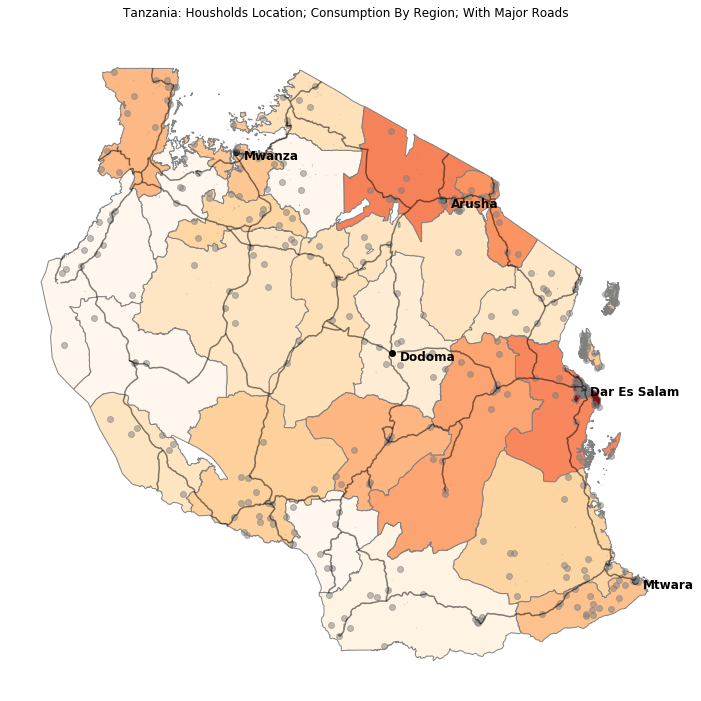

In [33]:
fig, ax = plt.subplots(figsize = (12,12))

# First create the map for the urban share

tanz_map.plot(ax = ax, edgecolor='tab:grey', column='log_cons', cmap='OrRd', alpha = 0.95)

roads_map.plot(ax = ax, color = 'k', alpha = 0.5)
## This adds the roads

newdata.plot(ax = ax, color = 'k')

hhdata.plot(ax = ax, color = 'tab:grey', alpha = 0.5)
## Plot the housholds on top of this...

######################################################################################
# populate with the city names
count = 0
for var in coordinates:
    
    citynames[count]
    
    ax.text(var[0]+0.15,var[1] -0.15,citynames[count], fontsize = 12, fontweight = "bold")
    
    count = count + 1

######################################################################################    
# Make it look preety...

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_title("Tanzania: Housholds Location; Consumption By Region; With Major Roads\n")

plt.show()

This is similar to the plots above, but here are couple of things to note...
- First note the dots on the map. These are the household locations.
- Second, notice how a majority of the sampling occurs near these major roads. This is kind of the key feature of being about to get the road map on the map. It shows how the (sampled) populating is all around the roads. 

Really cool.

### Tracking Households Across Time

Explore how income changes over time with rural urban status. Some tables and simple regression. Add in eduction.

In [34]:
tanz[tanz["urban_y1"] != tanz["urban_y2"]].region_y1.value_counts()
# This shows that there is something messed up with Zanzibar
# as in year 1 it is mostly urban, year 2 it is mostly rural.

Mjini/Magharibi Unguja    140
Mtwara                     54
Kusini Pemba               39
Dar es Salaam              34
Shinyanga                  30
Kaskazini Pemba            27
Ruvuma                     21
Kusini Unguja              20
Lindi                      19
Pwani                      18
Arusha                     14
Kilimanjaro                14
Mwanza                     14
Dodoma                     13
Tanga                      12
Mbeya                      10
Iringa                      9
Kagera                      9
Manyara                     8
Kigoma                      6
Morogoro                    6
Tabora                      5
Mara                        5
Rukwa                       4
Singida                     3
Kaskazini Unguja            1
Name: region_y1, dtype: int64

Lets look at where people are leaving from and where people are going....

In [35]:
outflow = tanz[(tanz["urban_y1"]== "Rural") & (tanz["urban_y2"]== "Urban")].region_y1.value_counts()
inflow = tanz[(tanz["urban_y1"]== "Rural") & (tanz["urban_y2"]== "Urban")].region_y2.value_counts()

in_out = pd.concat([outflow, inflow], axis = 1)
in_out.columns = ["out region (year 1)", "in region (year 2)"]

in_out.sort_values(by = "in region (year 2)", ascending = False).head(10)

,out region (year 1),in region (year 2)
Dar es Salaam,6,29
Shinyanga,16,20
Ruvuma,20,18
Mtwara,21,17
Lindi,18,13
Pwani,14,11
Mwanza,7,11
Kusini Unguja,11,11
Mbeya,10,11
Kilimanjaro,11,10


So one of the interesting things is that: Yes, there is movement into Dar es Salaam. But this is not the whole story. People are moving to other urban areas within Tanzania. But given the story in the regional evidence above, this suggests that their gains to moving will not be that large. That is they are entering better, but not Dar es Salaam type markets.

What I should do is compare urban consu

In [36]:
tanz["rural_switch"] = np.where((tanz["urban_y1"]== "Rural") & (tanz["urban_y2"]== "Urban") 
                                & (tanz["region_y1"] == tanz["region_y2"]) 
                                & (tanz["region_y2"] != "Dar es Salaam") , 1,0)

In [37]:
tanz.rural_switch.sum()

160

In [38]:
results = smf.ols('''cons_growth ~ rural_switch ''', 
                  data= tanz).fit() 

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cons_growth   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.40
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           0.000255
Time:                        16:13:36   Log-Likelihood:                -21265.
No. Observations:                3838   AIC:                         4.253e+04
Df Residuals:                    3836   BIC:                         4.255e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       16.3820      1.017     16.107      0.000      14.388      18.376
rural_switch    18.2323      4.981      3.660      0.000       8.466      27.999
==============================================================================
Omnibus:                       49.764   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.017
Skew:                           0.048   Prob(JB):                     1.27e-19
Kurtosis:                       3.731   Cond. No.                         5.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lets think about what this says. So if you do not move, the `rural_switch` value takes a zero, then this says average consumption growth is 15 percent. If you do more, you get 15 percent + 33 or 48 percent in total.

Now lets put this in perspective:
- In both years, urban residents earn about twice as much as rural residents. So a "naive" interpretation this is that if some body moved from a rural to urban area, then they could double their wages.
- This result says, those that do move...are better off. They receive a bump in consumption of 33 percent. But this is less than the 100 percent difference in consumption between locations. This means that???

## Summary

Summarize what I find